# Never Drive Alone: Boosting carpooling with network analysis

Santiago Angée-Agudelo
Universidad Eafit
E-mail: sangeea@eafit.edu.co

This is an implementation of the algorithms presented in [5] to identify carpooling communities. In this notebook we intend to do a first approach for the implementation of the definitions and algorithms presented in [1].

This work is divided in two steps:

The first step is to extract the mobility profiles of each user. The second step is to calculate the carpooling network by using the calculated mobility profiles.

## Objectives

The general objective of this work is to define a carpooling network using a different dataset from the original study, to encourage and find out possible strategies from the data science to boost carpooling in the city of Medellín.

The project's specific objectives are:

- To apply route mining techniques to identify routines and mobility profiles in users
- To apply route mining techniques to extract a set of trips given a set of GPS coordinates for several users
- To build a carpooling network, where an edge from a node u to a node v means that v can share her car to do carpooling with u

## Dataset

The used dataset can be found on the following web address:

https://www.microsoft.com/en-us/download/details.aspx?id=52367

The complete dataset description is included in the file named "User Guide-1.3.pdf" that is included in this repo.

Before reading this notebook please refer to this guide to understand the dataset.

To summarize, the dataset consists of a set of points in the form of GPS coordinates for 182 users, most of the users are located in Asia, mainly in the Beijing area.

# Step 0: Trajectory definition

## Definition 1: User history

The following definitions can be found in [4]. The original paper [1] is based on the work made by [2] to mine users' trips

![title](img/Selection_055.png) [4]

In [2]:
# trajectory module
import os
import numpy as np
import math
from IPython.core.debugger import Tracer

DATASET_DIR = "/home/sangeea/Eafit/2017-1/Network Analysis/Geolife Trajectories 1.3/Data"
DATASET_FILE_PATH = "/home/sangeea/Eafit/2017-1/Network Analysis/Geolife Trajectories 1.3/Data/%s/Trajectory"

class Trajectory(list):
    def append(x,y,timestamp):
        super().append((x,y,timestamp))

class User(object):
    """
    attributes: id
                history: set(Trajectory)
                points: list(3-tuple: x,y, timestamp)
                trips: list(points)
                mobility_profile: list(trip)
                """
    
    def __init__(self, user_id):
        self.id = user_id
        self.history = set()
        self.points = []
        self.trips = []
        self.mobility_profile = []
        
    def add_trajectory(self, trajectory):
        
        if type(trajectory) == "Trajectory":
            self.add(trajectory)
        else:
            raise TypeNotSupportedError("only elements of type 'Trajectory' are allowed in the user story")
        
# Load the dataset into memory. Create the users

users_str = [f for f in os.listdir(DATASET_DIR)]

users_str.sort()

Users = []

for user_str in users_str:
    Users.append(User(user_str))
    

for user in Users:
    files = [f for f in os.listdir((DATASET_FILE_PATH %(user.id)))]
    files.sort()
    files = [(DATASET_FILE_PATH %(user.id)) + "/" + f for f in files]
    for file in files:
        user.points.extend(np.genfromtxt(file, skip_header=6,
                                    delimiter=",", dtype="float", usecols=(0,1,4)))
    

## Definition 2 (Potential Stops)

![title](img/Selection_056.png) [4]

In [9]:
from geopy.distance import great_circle


# Point distance function. returns the distance in meters of two points,
# given two gps coordinates in the form (x,y,days since 12/30/1899)
def point_distance(point1, point2):
    x = 0
    y = 1
    return great_circle((point1[x], point1[y]),(point2[x],point2[y])).meters

def duration(point1, point2):
    return (point2[2] - point1[2])*24 # a day has 24 hours

num_points = 0
for user in Users:
    num_points = num_points + len(user.points)
    
print("Number of observations = %d" %(num_points))

# Returns True if range1 is contained into range2, false otherwise
def contained(range1, range2):
    start = 0
    end = 1
    return (range1[start] == range2[start] and range1[end] < range2[end]) or \
            (range1[start] > range2[start] and range1[end] < range2[end]) or \
            (range1[start] > range2[start] and range1[end] == range2[end]) or \
            (range1[start] == range2[start] and range1[end] == range2[end])
    
# Potential stops
# threshold stop spatial used = 250m
# threshold stop temporal used = 1 hour
def potential_stops(points, th_stop_spatial, th_stop_temporal):
    
    #These are alias for tuple readability on potential stops
    start = 0
    end = 1
    
    S = []
    n = len(points)
    m = 0
    k = 1
    
    potential_stop_index = -1
    
    while m < n - 1:
        i = 1
        while m + i < n:
            # first case: several distances are calculated
            if point_distance(points[m], points[m + i]) <= th_stop_spatial and \
            m + i < n - 1: 
                i = i + 1
            elif m + i == n - 1 and point_distance(points[m],points[m+i]) <= th_stop_spatial:
                k = m + i
                if k - m > 0 and duration(points[m], points[k]) >= th_stop_temporal:
                    potential_stop = (m,k+1)
                    S.append(potential_stop)
                    potential_stop_index = potential_stop_index + 1
                m = n - 1
                break
            else:
                # This is not a potential stop
                k = m + i - 1
                # At this point we are absolutely sure, this is a subsequence
                if k - m  > 0 and duration(points[m], points[k]) >= th_stop_temporal:
                    # check that the potential stop is not included in the
                    #previous potential stop
                    if potential_stop_index >= 0 and \
                    not contained((m, k+1), S[potential_stop_index]):
                        potential_stop = (m,k+1)
                        S.append(potential_stop)
                        potential_stop_index = potential_stop_index + 1
                    elif potential_stop_index == -1:
                        potential_stop = (m,k+1)
                        S.append(potential_stop)
                        potential_stop_index = potential_stop_index + 1
                    else:
                        pass
                break
        m = m + 1
    
    return S

#S = potential_stops(Users[0].points, 250, 1)


Number of observations = 24876978


## Definition 3: Actual Stops

![title](img/Selection_057.png) [4]

In [10]:
# Test if the potential stops are valid i.e the first index of an element i
# is not greater than the first element of an element i+1
def test_potential_stops(points):
    
    for i in range(0,len(points)-1):
        if points[i][0] > points[i+1][0] or points[i][0] > points[i][1]:
            return False

    return True

# test_potential_stops(S)

# Returns True if there are common elements between range1, and range2; false otherwise
def intersection(range1, range2):
    start = 0
    end = 1
    return range2[start] < range1[end]

def actual_stops(potential_stops):
    S = potential_stops
    
    if len(S) == 0:
        return []
    
    ActS = [S[0]]
    
    for i in range(0, len(S)):
        if S[i] in ActS:
            for j in range(i + 1, len(S)):    
                if not intersection(S[i], S[j]):
                    ActS.append(S[j])
                    break
    
    return ActS

def test_actual_stops(stops):
    start = 0
    end = 1
    current = 0
    for stop in stops:
        if current > stop[start]:
            Tracer()()
            return False
        
        if stop[start] >= stop[end]:
            Tracer()()
            return False
        
        current = stop[end]
    
    return True
        
#ActS = actual_stops(S)
#print(test_actual_stops(ActS))

## Trips

![title](img/Selection_058.png) [4]

In [11]:


def temporal_alignment_constraint(trajectory1, trajectory2, time_threshold):
    return duration(trajectory1, trajectory2) <= time_threshold

def create_trips(points, actual_stops):
    n = len(points)
    start = 0
    end = 1
    
    S = actual_stops
    
    T = []
    if len(actual_stops) == 0:
        trip = (0, n)
        T.append(trip)
        return T
    elif len(actual_stops) == 1:
    # Case where len(actual_stops) == 1
        if S[0][start] == 0 and S[0][end] == n:
            return []
        if S[0][start] > 0:
            trip = (0, S[0][start]+1)
            T.append(trip)
        if S[0][end] < n:
            trip = (S[0][end] - 1, n)
            T.append(trip)
        return T
    
    else:
        # Cases where len(actual_stops) >= 2
        for i in range(0, len(actual_stops) - 1):
        
            S[i] == actual_stops[i]
            if i == 0 and S[i][start] > 0:
                trip = (0, S[i][start]+1)
                T.append(trip)
        
            S[i+1] = actual_stops[i+1]
            trip = (S[i][end]-1, S[i+1][start]+1)
            T.append(trip)
        
            if i == len(actual_stops) - 2 and S[i+1][end] < n:
                trip = (S[i+1][end]-1, n)
                T.append(trip)
        
        return T
    

#T = trips(Users[0].points, ActS)

## Create trips

In [12]:
# A class representing a Trip. Refer to definiton 4

class Trip(object):
    """
    attributes: id(Integer),
                points(Trajectory),
                start_index(Integer),
                end_index(Integer)
                """
    
    def __init__(self, trip_id, points, start_index, end_index):
        self.id = trip_id
        self.points = points
        self.start_index = start_index
        self.end_index = end_index
        
        
    def set_core_distance(self, neighbours, epsilon, min_neighbours):
        ID, TRIP, DISTANCE = 0,1,2
        
        # Not a core object
        if len(neighbours) < min_neighbours:
            self.core_distance = float("inf")
            return
    
        neighbours.sort(key=lambda x: x[2])
    
        self.core_distance = neighbours[min_neighbours-1][DISTANCE]
        return True
        
    
    def set_neighbours(trips_set, distance_function, epsilon):
        neighbours = []
    
        for idx, trip in enumerate(trips_set):
            distance = distance_function(current_trip.points, trip.points)
            if distance <= epsilon and trip != current_trip:
                neighbours.append((trip, distance))
       
        self.neighbours = neighbours
        return True
        
        
def add_trips(user):
    pstops = potential_stops(user.points, 250, 1)
    astops = actual_stops(pstops)
    trps = create_trips(user.points, astops)
    trips = []
    for idx, trip in enumerate(trps):
        trips.append(Trip(idx, user.points[trip[0]:trip[1]], trip[0],trip[1]))
        
    user.trips = trips
    return True

#trips = add_trips(Users[0])
#trips = Users[0].trips

## Route Similarity Function

Define a route similarity function to calculate the clustering of the trip groups. The similarity function used for this work can be found in [6]. The authors in [4] and [5] (study, on which we based this work) used this distance function to calculate the mobility profiles.

Another distance functions, such as the Frechét distance and polygonal distance, respectively found in [7] and [8]

![title](img/Selection_059.png) [6]

In [13]:
""" Giver two trajectories T and T', a trajectory distance function Dist and a
    distance threshold epsilon, we say that T is similar to T'
    iff Dist(T, T') <= epsilon 
    Output. distance between P and Q"""

from scipy.spatial.distance import euclidean


def route_similarity(trajectory1, trajectory2, threshold):
    P = trajectory1; Q = trajectory2; D = threshold
    dist = 0; pen = 0 # distance and penalty
    n = 0             # number of corresponding points
    i = 0; j = 0      # indices of points in P and Q

    while i < len(P) and j < len(Q):
        d = point_distance(P[i],Q[j])
        while i+1 < len(P) and \
        point_distance(P[i+1], Q[j]) < d:
            pen = pen + point_distance(P[i],P[i+1])
            i = i+1
            d = point_distance(P[i], Q[j])

        while j+1 < len(Q) and \
        point_distance(P[i], Q[j+1]) < d:
            pen = pen + point_distance(Q[j], Q[j+1])
            j = j+1
            d = point_distance(P[i],Q[j])
            
        dist = dist + d
        n = n+1
        if dist/float(n) > D:
            return D*2
        pen = pen - (D - d)
        i = i+1
        j = j+1
    dist = dist/float(n)
    while i < len(P):
        pen = pen + point_distance(P[i-1], P[i])
        i = i+1
    while j < len(Q):
        pen = pen + point_distance(Q[j-1], Q[j])
        j = j+1

    return dist + pen

def spatial_distance_function(trajectory1, trajectory2):
    return route_similarity(trajectory1, trajectory2, 1000)

# Test route similarity function

# test_trips =trips[0:100]

# for i in range(len(test_trips)):
#    for j in range(len(test_trips)):
#        print("%0.2f " % (route_similarity(test_trips[i].points, test_trips[j].points, 1000)), end='')
#    print("\n")

# print(route_similarity(trip1.points, trip2.points, 1000))

# print(route_similarity_euclidean(route_test_case1,route_test_case2, 0.1))
    

## Definition 5 (Trip group)

![title](img/Selection_060.png) [4]

I used the definition trip group definition in [4], by using the route similarity function and a clustering technique to extract each user's mobility profile. The time function was not used because this computation required a lot of time (2 days to calculate the mobility profile for 30 users on a intel Core i7 6th generation machine). Therefore the trip groups and the mobility profiles were extracted using only a distance function.

In this section I use the OPTICS algorithm because it was the method proposed by [4] to achieve an accurate mobility profile for each user in comparison to other clustering techniques such as DBSCAN, Also to extract the mobility profiles a K-means algorithm is not suitable due to the computational cost of continuosly calculating the new mean. For this reason an algorithm of the k-medoids familya, OPTICS, a variation of DBSCAN was employed [9]. There is an explanation of the implementation of this algorithm for trajectories in [10]. However, no literature was found comparing different clustering algorithms for routes mining.

The optics algorithm implementation in the file "optics.py" was slightly modified by me to include general distance functions instead of mere points.

## Mobility Profile Extraction

The following is the definition of mobility profile, taken from [5]:

![title](img/Selection_061.png)[5]

![title](img/Selection_064.png) [4]

In [14]:
import optics

import matplotlib.pyplot as plt

import plotly.plotly as py


def get_mobility_profile(user):
    optics_instance = optics.optics(user.trips, 500, 3, spatial_distance_function);
        
    # Run cluster analysis
    optics_instance.process();
        
    # Obtain results of clustering
    clusters = optics_instance.get_clusters();
    
    user.mobility_profile.extend([user.trips[cluster[0]] for cluster in clusters])
    
    return True

def get_mobility_profiles(users):
    [get_mobility_proile(user) for user in users]
    return True

## Output clusters to text file

The following code is meant to output the routine trips by cluster to a new csv file with the following form:

user_id: id of the user that did the trip

trip_id: id of the trip

trip_start: start index of the trip in the original dataset

trip_end: end index of the trip in the original dataset

For each user, there is a .csv file inside the routes/ folder with the id of the user (e.g. "001.csv").

In [15]:
ROUTINES_PATH = "./routines/%s.csv"

# get_mobility_profile(Users[0])

# This code is for batch processing, it is commented because it must be run only once and takes a lot of time
"""for user in Users[30:33]:
    add_trips(user)
    get_mobility_profile(user)
    file_str = user.id
    file = open(ROUTINES_PATH %(user.id), "w")
    for routine in user.mobility_profile:
        line = ("%s %s %s %s\n" %(user.id, routine.id, routine.start_index, routine.end_index))
        file.write(line)
        
    file.close() """

'for user in Users[30:33]:\n    add_trips(user)\n    get_mobility_profile(user)\n    file_str = user.id\n    file = open(ROUTINES_PATH %(user.id), "w")\n    for routine in user.mobility_profile:\n        line = ("%s %s %s %s\n" %(user.id, routine.id, routine.start_index, routine.end_index))\n        file.write(line)\n        \n    file.close() '

## Routine containment

![title](img/Selection_062.png) [5]


## Carpooling Community

![title](img/Selection_065.png) [5]

Carpooling network:

![title](img/Selection_066.png) [5]

In [34]:
import networkx as nx

def is_contained(routine1, routine2, spatial_tolerance, temporal_tolerance):
    
    for i in range(0, len(routine2)-1):
        for j in range(i+1,len(routine2)):
            spatial_dist = \
            point_distance(routine1[0], routine2[i]) + \
            point_distance(routine1[len(routine1)-1],routine2[j])
            
            temporal_dist = abs(duration(routine1[0], routine2[i])) + \
            abs(duration(routine1[len(routine1)-1], routine2[j]))
            
            if spatial_dist <= spatial_tolerance and \
            temporal_dist <= temporal_tolerance:
                return True
    
    return False

def create_carpooling_network(users, spatial_tolerance, temporal_tolerance):
    
    G = nx.DiGraph()
    
    for i in range(0, len(users)):
        routines_i = users[i].mobility_profile
        for j in range(0, len(users)):
            if users[i] != users[j]:
                routines_j = users[j].mobility_profile
                
                for routine_i in routines_i:
                    for routine_j in routines_j:
                        if is_contained(routine_i.points, routine_j.points,
                                       spatial_tolerance,
                                       temporal_tolerance):
                            G.add_edge(users[i].id,users[j].id)
    
    return G

def recover_mobility_profiles(users):
    
    
    
    for user in users:
        user.mobility_profile = []
        file = (ROUTINES_PATH %(user.id))
        records = np.genfromtxt(file, delimiter=" ", dtype="int")
        if len(records) > 0 and type(records[0]) is np.int64:
            trip = Trip(records[1], user.points[records[2]:records[3]],records[2],records[3])
            user.mobility_profile.append(trip)
        else:
            for record in records:
                trip = Trip(record[1], user.points[record[2]:record[3]],record[2],record[3])
                user.mobility_profile.append(trip)

recover_mobility_profiles(Users[0:32])
        
print(is_contained(Users[0].mobility_profile[0].points,Users[1].mobility_profile[0].points, 1000, 1))
G = create_carpooling_network(Users[0:5], 1000, 1)
                            
                            
            

/home/sangeea/anaconda3/lib/python3.6/site-packages/numpy/lib/npyio.py:1487: UserWarning:

genfromtxt: Empty input file: "./routines/021.csv"

/home/sangeea/anaconda3/lib/python3.6/site-packages/numpy/lib/npyio.py:1487: UserWarning:

genfromtxt: Empty input file: "./routines/027.csv"

/home/sangeea/anaconda3/lib/python3.6/site-packages/numpy/lib/npyio.py:1487: UserWarning:

genfromtxt: Empty input file: "./routines/031.csv"



False


KeyboardInterrupt: 

--Return--
None
> <ipython-input-36-ddb6375c8852>(4)<module>()
      2 get_ipython().magic('matplotlib inline')
      3 
----> 4 Tracer()()
      5 
      6 DG = nx.DiGraph()

ipdb> continue
['000', '003', '004']


/home/sangeea/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning:

pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.

/home/sangeea/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning:

pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.

/home/sangeea/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning:

axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.

/home/sangeea/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning:

axes.hold is deprecated, will be removed in 3.0



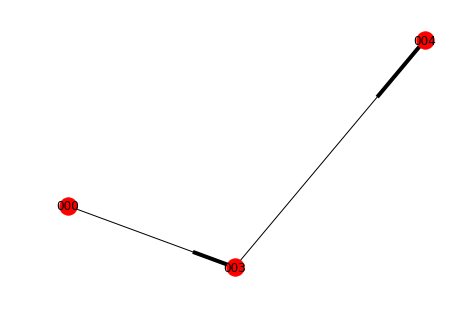

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

Tracer()()

DG = nx.DiGraph()

DG.add_edges_from(G.edges())
print(DG.nodes())

nx.draw(DG,with_labels=True)  # networkx draw()
plt.draw()

## Interpretation of results

The following carpooling community definition was used with only five Users, this was because the processing time was very big. For the processing of five graphs it took an approximate execution time of 3 hours. It is pending the processing of all the nodes.

## Further work

As further work, it is left to improve the efficiency of the algorithms. Maybe by using another programming language like C/C++ and using a parallel programming model (e.g. MPI, Spark). Due to time restrictions the extraction of the entire carpooling network was not possible. However, as an example, this is the extraction of a carpooling network for the users 000, 001, 002, 003, 004

## Conclusion

The extraction of trips, mobility profiles, common routines and a carpooling community was possible using the methods proposed by [4], [5] and [6]. In this work we have confirmed that the creation of a carpooling community using route mining techniques is possible and hence, it could be implemented in a city like Medellín to encourage the adoption of carpooling. Nevertheless, the complete network construction as well as the carpooling network analysis is left for a further phase of this work, which could be my master's thesis.

## References

[1] Yu Zheng, Lizhu Zhang, Xing Xie, Wei-Ying Ma. Mining interesting locations and travel sequences from GPS trajectories. In
Proceedings of International conference on World Wild Web (WWW 2009), Madrid Spain. ACM Press: 791-800.

[2] Yu Zheng, Quannan Li, Yukun Chen, Xing Xie, Wei-Ying Ma. Understanding Mobility Based on GPS Data. In Proceedings of
ACM conference on Ubiquitous Computing (UbiComp 2008), Seoul, Korea. ACM Press: 312-321.

[3] Yu Zheng, Xing Xie, Wei-Ying Ma, GeoLife: A Collaborative Social Networking Service among User, location and trajectory.
Invited paper, in IEEE Data Engineering Bulletin. 33, 2, 2010, pp. 32-40.

[4] R. Trasarti, F. Pinelli, M. Nanni, and F. Giannotti, “Mining mobility user profiles for car pooling,” … Discov. Data Min., no. iii, pp. 1190–1198, 2011.

[5] R. Guidotti, M. Nanni, S. Rinzivillo, D. Pedreschi, and F. Giannotti, “Never drive alone: Boosting carpooling with network analysis,” Inf. Syst., vol. 64, pp. 237–257, 2014.

[6] G. Andrienko, N. Andrienko, and S. Wrobel, “Visual analytics tools for analysis of movement data,” ACM SIGKDD Explor. Newsl., vol. 9, no. 2, p. 38, 2007.

[7] G. Trajcevski, H. Ding, P. Scheuermann, R. Tamassia, and D. Vaccaro, “Dynamics-aware similarity of moving objects trajectories,” Proc. 15th Annu. ACM Int. Symp. Adv. Geogr. Inf. Syst.  - GIS ’07, p. 1, 2007.

[8] N. Pelekis, I. Kopanakis, G. Marketos, I. Ntoutsi, G. Andrienko, and Y. Theodoridis, “Similarity search in Trajectory Databases,” Proc. Int. Work. Temporal Represent. Reason., pp. 129–140, 2007.

[9] M. Ankerst, M. M. Breunig, H.-P. Kriegel, and J. Sander, “Optics: Ordering points to identify the clustering structure,” ACM Sigmod Rec., pp. 49–60, 1999.

[10] S. Rinzivillo, D. Pedreschi, M. Nanni, F. Giannotti, N. Andrienko, and G. Andrienko, “Visually Driven Analysis of Movement Data by Progressive Clustering,” Inf. Vis., vol. 7, no. 3–4, pp. 225–239, 2008.